In [1]:
%matplotlib inline  
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from pylab import rcParams

pd.options.mode.chained_assignment = None  # default='warn'

sns.set_color_codes("bright")
pd.set_option('max_columns', 160)
pd.set_option('max_rows', 100)
sns.set(font_scale=1.25)
sns.set_style("white")


In [2]:
masterfile = open("CDSrc_guides.cleaned.csv","r")
global_gRNA_idx = 0
global_gRNA_dict = {}
for line in masterfile:
    line = line.strip()
    entries = line.split(",")
    mastergRNAseq = entries[5] 
    global_gRNA_dict[mastergRNAseq] = global_gRNA_idx  #store the gRNA sequence as a key, value is position in array
    global_gRNA_idx += 1
    
allCounts = {}

# files are renamed for ease of processing. 
# prefix with "D" = +dCas9 and with "W" = -dCas9
# time of sample extraction is indicated either as "00" = initial or "08" = after 8 hours growth
# media used for culturing indicated as "LB3", "M92G" = with glucose, "M92S" = with sucrose
# replicates are suffixed with "a" or "b"
samplenames = ['D00','D08_LB3a','D08_LB3b','D08_M92Ga','D08_M92Gb','D08_M92Sa','D08_M92Sb','W00','W08_LB3a','W08_LB3b','W08_M92Ga','W08_M92Gb','W08_M92Sa','W08_M92Sb']
for sample in samplenames:
    file = glob.glob(sample+"*.uniq")
    print(file[0])
    for filehandle in file:
        currCount = {}
        currFile = open(filehandle,"r")
        for line2 in currFile:
            line2 = line2.strip()
            entries2 = line2.split()
            if(len(entries2)>1):
                counts = entries2[0]
                seq = entries2[1]
                if(len(seq)==20 and seq in global_gRNA_dict):
                    currCount[seq] = int(counts)
        allCounts[sample] = currCount

D00.fastq.trimmed.seq.uniq
D08_LB3a.fastq.trimmed.seq.uniq
D08_LB3b.fastq.trimmed.seq.uniq
D08_M92Ga.fastq.trimmed.seq.uniq
D08_M92Gb.fastq.trimmed.seq.uniq
D08_M92Sa.fastq.trimmed.seq.uniq
D08_M92Sb.fastq.trimmed.seq.uniq
W00.fastq.trimmed.seq.uniq
W08_LB3a.fastq.trimmed.seq.uniq
W08_LB3b.fastq.trimmed.seq.uniq
W08_M92Ga.fastq.trimmed.seq.uniq
W08_M92Gb.fastq.trimmed.seq.uniq
W08_M92Sa.fastq.trimmed.seq.uniq
W08_M92Sb.fastq.trimmed.seq.uniq


In [3]:
#tabulate and merge the counts with the master table
guideStat = pd.read_csv("CDSrc_guides.cleaned.csv",sep = ',', names=['FIG','strand','bp_start','geneLength','per','seq'])

temp = pd.DataFrame.from_dict(allCounts)
temp.reset_index(inplace=True)
gRNA = pd.merge(guideStat,temp,how='inner',left_on='seq',right_on='index')
gRNA.drop(columns=['index'],inplace=True)
gRNA.fillna(0,inplace=True) #for gRNAs with no counts, put in a minimum value to avoid divide by NA

In [4]:
#function to normalize each experimental column to reads per million

def norm_rpm(df):
    cols = df.columns.tolist()
    for col in cols:
        if(col not in ["FIG","strand","bp_start","geneLength","per","seq"]):
            df[col+"_rpm"] = df[col].divide(df[col].sum())*1000000
    return df

In [5]:
#normalize all experimental conditions to reads per million
gRNA_rpm = norm_rpm(gRNA)
gRNA_rpm.head(5)
gRNA_rpm.to_csv("gRNA_raw_rpm.csv",sep=",")

In [6]:
gRNA_rpm.head(2)

,FIG,strand,bp_start,geneLength,per,seq,D00,D08_LB3a,D08_LB3b,D08_M92Ga,D08_M92Gb,D08_M92Sa,D08_M92Sb,W00,W08_LB3a,W08_LB3b,W08_M92Ga,W08_M92Gb,W08_M92Sa,W08_M92Sb,D00_rpm,D08_LB3a_rpm,D08_LB3b_rpm,D08_M92Ga_rpm,D08_M92Gb_rpm,D08_M92Sa_rpm,D08_M92Sb_rpm,W00_rpm,W08_LB3a_rpm,W08_LB3b_rpm,W08_M92Ga_rpm,W08_M92Gb_rpm,W08_M92Sa_rpm,W08_M92Sb_rpm
0,FIG|691.12.PEG.1,rc,18,1341,0.01342,AGGCTTGGCAACTGTTCGAA,586.0,24.0,43.0,27.0,40.0,31.0,34.0,153.0,186.0,179.0,137.0,61.0,238.0,111.0,90.368060,5.015701,8.312918,4.738649,5.577782,5.191581,6.713623,42.56606,38.133923,36.899966,30.227172,21.735738,34.298787,34.262167
1,FIG|691.12.PEG.1,rc,33,1341,0.02461,TCAGGATTTACTGCGAGGCT,119.0,6.0,12.0,5.0,6.0,10.0,2.0,329.0,232.0,249.0,262.0,160.0,401.0,136.0,18.351193,1.253925,2.319884,0.877528,0.836667,1.674704,0.394919,91.53094,47.564893,51.330120,57.806708,57.011771,57.789132,41.978872


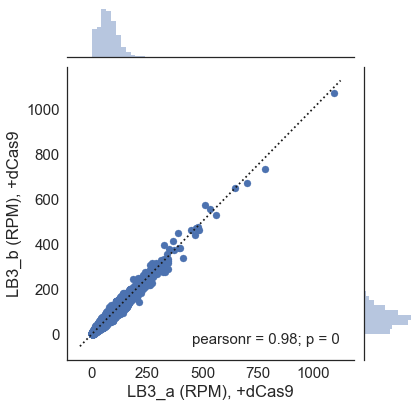

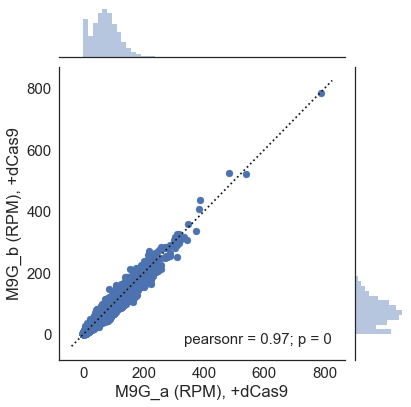

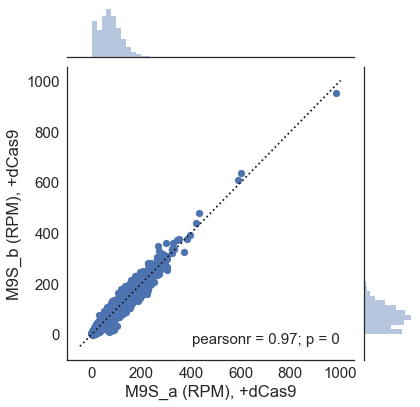

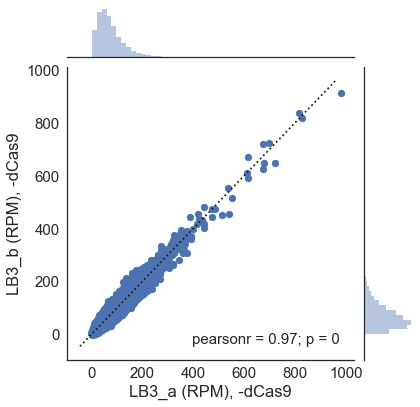

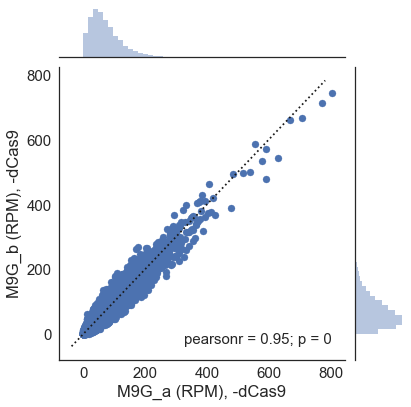

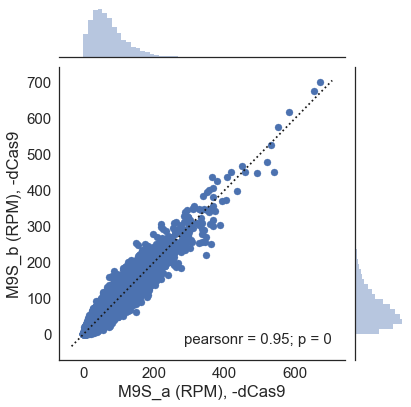

In [7]:
#look at the reproducibility of gRNA duplicates (normalized as RPM) per condition

fig = plt.figure()  
sns.set(font_scale=1.5)
sns.set_style("white")


g=sns.jointplot(x="D08_LB3a_rpm",y="D08_LB3b_rpm",data=gRNA_rpm)
g.ax_joint.get_legend()._set_loc(4)
g.ax_joint.set_xlabel('LB3_a (RPM), +dCas9')
g.ax_joint.set_ylabel('LB3_b (RPM), +dCas9')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
# plt.savefig("LB3+dCas9.png",dpi=600)


g=sns.jointplot(x="D08_M92Ga_rpm",y="D08_M92Gb_rpm",data=gRNA_rpm)
g.ax_joint.get_legend()._set_loc(4)
g.ax_joint.set_xlabel('M9G_a (RPM), +dCas9')
g.ax_joint.set_ylabel('M9G_b (RPM), +dCas9')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
# plt.savefig("M9G+dCas9.png",dpi=600)


g=sns.jointplot(x="D08_M92Sa_rpm",y="D08_M92Sb_rpm",data=gRNA_rpm)
g.ax_joint.get_legend()._set_loc(4)
g.ax_joint.set_xlabel('M9S_a (RPM), +dCas9')
g.ax_joint.set_ylabel('M9S_b (RPM), +dCas9')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
# plt.savefig("M9S+dCas9.png",dpi=600)



g=sns.jointplot(x="W08_LB3a_rpm",y="W08_LB3b_rpm",data=gRNA_rpm)
g.ax_joint.get_legend()._set_loc(4)
g.ax_joint.set_xlabel('LB3_a (RPM), -dCas9')
g.ax_joint.set_ylabel('LB3_b (RPM), -dCas9')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
# plt.savefig("LB3-dCas9.png",dpi=600)


g=sns.jointplot(x="W08_M92Ga_rpm",y="W08_M92Gb_rpm",data=gRNA_rpm)
g.ax_joint.get_legend()._set_loc(4)
g.ax_joint.set_xlabel('M9G_a (RPM), -dCas9')
g.ax_joint.set_ylabel('M9G_b (RPM), -dCas9')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
# plt.savefig("M9G-dCas9.png",dpi=600)


g=sns.jointplot(x="W08_M92Sa_rpm",y="W08_M92Sb_rpm",data=gRNA_rpm)
g.ax_joint.get_legend()._set_loc(4)
g.ax_joint.set_xlabel('M9S_a (RPM), -dCas9')
g.ax_joint.set_ylabel('M9S_b (RPM), -dCas9')
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')
# plt.savefig("M9S-dCas9.png",dpi=600)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


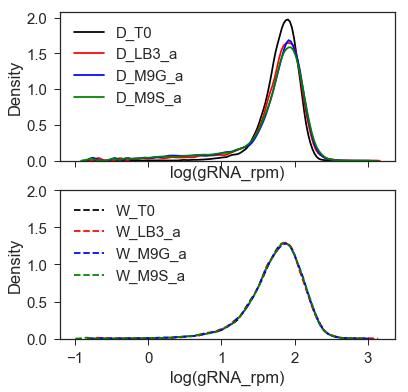

In [8]:
# visualize the distribution of gRNAs (expressed in log(RPM)). 
# There will be 'divide by zero' but this is okay for visualization purposes
# MAGEcK will handle these cases for analysis. 

import matplotlib.ticker as plticker

sns.set_style('ticks')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(6,6))
ax1.set_ylim([0, 2])
ax2.set_ylim([0, 2])

loc = plticker.MultipleLocator(base=0.5) 
ax1.yaxis.set_major_locator(loc)

loc = plticker.MultipleLocator(base=0.5) 
ax2.yaxis.set_major_locator(loc)

sns.distplot(np.log10(gRNA_rpm["D00_rpm"]), kde=True,hist=False,bins=200, color='black',label="D_T0",
            hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "black"},ax=ax1)
sns.distplot(np.log10(gRNA_rpm["D08_LB3a_rpm"]), kde=True, hist=False,bins=200, color='red',label="D_LB3_a",
            ax=ax1)
sns.distplot(np.log10(gRNA_rpm["D08_M92Ga_rpm"]), kde=True, hist=False,bins=200, color='blue',label="D_M9G_a",
            ax=ax1)
sns.distplot(np.log10(gRNA_rpm["D08_M92Sa_rpm"]), kde=True, hist=False,bins=200, color='green',label="D_M9S_a",
            ax=ax1)

ax1.set(xlabel='log(gRNA_rpm)', ylabel='Density')

sns.distplot(np.log10(gRNA_rpm["W00_rpm"]), kde=True,hist=False,bins=200, color='black',label="W_T0",
            hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "black"},ax=ax2,
            kde_kws={'linestyle':'--'})
sns.distplot(np.log10(gRNA_rpm["W08_LB3a_rpm"]), kde=True, hist=False,bins=200, color='red',label="W_LB3_a",
            ax=ax2,kde_kws={'linestyle':'--'})
sns.distplot(np.log10(gRNA_rpm["W08_M92Ga_rpm"]), kde=True, hist=False,bins=200, color='blue',label="W_M9G_a",
            ax=ax2,kde_kws={'linestyle':'--'})
sns.distplot(np.log10(gRNA_rpm["W08_M92Sa_rpm"]), kde=True, hist=False,bins=200, color='green',label="W_M9S_a",
            ax=ax2,kde_kws={'linestyle':'--'})
ax2.set(xlabel='log(gRNA_rpm)', ylabel='Density')

plt.legend()
# plt.savefig('Media_RPMs.pdf')

In [9]:
# test = gRNA_rpm.reset_index()
# gRNA_rpm["test"] = test["FIG"].astype(str).str.cat(test["index"].astype(str),sep="_")
# gRNA_rpm.head(5)
# # temp.seq.astype(str).str.cat(temp.FIG.astype(str), sep=';')

In [10]:
# make a single list of FIGs which combines gRNA sequences from +dCas9 and -dCas9 cells 
# to do so, duplicate the gRNA list, prefix FIGs and sequences from dCas9 cells with "NT" = non-targeting
# and concat as one large list

temp = gRNA_rpm[["seq","FIG"]]
temp2 = gRNA_rpm[["seq","FIG"]]  

temp2["FIG"] = "NT_"+temp["FIG"].astype(str)
temp2["seq"] = "NT_"+temp["seq"].astype(str)
temp2 = temp2.reset_index()

temp2["FIG"] = temp2["FIG"].astype(str).str.cat(temp2["index"].astype(str),sep="_")
temp['seq;FIG'] = temp.seq.astype(str).str.cat(temp.FIG.astype(str), sep=';')
temp2['seq;FIG'] = temp2.seq.astype(str).str.cat(temp2.FIG.astype(str), sep=';')

gRNA_rpm_count = pd.concat([temp[['seq;FIG']],temp2[['seq;FIG']]],ignore_index=True)
gRNA_rpm_count.head(5)

# gRNA_rpm_count.to_csv("combined_gRNA.txt")

,seq;FIG
0,AGGCTTGGCAACTGTTCGAA;FIG|691.12.PEG.1
1,TCAGGATTTACTGCGAGGCT;FIG|691.12.PEG.1
2,AGTCCTCAGGATTTACTGCG;FIG|691.12.PEG.1
3,ACTTCTATGATTAATGAGTT;FIG|691.12.PEG.2
4,TTAATGAGAGGAAGCTTGAT;FIG|691.12.PEG.2


In [11]:
def returnCompressedCol(df_out,df_in,conditions):
    #df_out is the merged dataframe 
    #df_in is the dataframe with counts
    #condition is the label of the column without D or W designation
    for cond in conditions:
        w_condition = "W"+cond+"_rpm"
        d_condition = "D"+cond+"_rpm"
        temp = df_in[["seq","FIG",w_condition]]
        temp["FIG"] = "NT_"+temp["FIG"].astype(str)
        temp["seq"] = "NT_"+temp["seq"].astype(str)
        temp_reset = temp.reset_index()
        temp["FIG"] = temp_reset["FIG"].astype(str).str.cat(temp_reset["index"].astype(str),sep="_")
        temp.columns.values[2] = d_condition

        temp2 = df_in[["seq","FIG",d_condition]]

        temp['seq;FIG'] = temp.seq.astype(str).str.cat(temp.FIG.astype(str), sep=';')
        temp2['seq;FIG'] = temp2.seq.astype(str).str.cat(temp2.FIG.astype(str), sep=';')

        temp3 = pd.concat([temp[['seq;FIG',d_condition]],temp2[['seq;FIG',d_condition]]],ignore_index=True)
        df_out = pd.merge(df_out,temp3,how="outer",on="seq;FIG")    
    return df_out
    
    

In [12]:
conditions = ["00","08_LB3a","08_LB3b","08_M92Sa","08_M92Sb","08_M92Ga","08_M92Gb"]

compressed_gRNA_rpm = returnCompressedCol(gRNA_rpm_count,gRNA_rpm, conditions)
compressed_gRNA_rpm['seq'], compressed_gRNA_rpm['FIG'] = compressed_gRNA_rpm['seq;FIG'].str.split(';', 1).str
compressed_gRNA_rpm.drop(columns=["seq;FIG"],inplace=True)
seq = compressed_gRNA_rpm["seq"]
FIG = compressed_gRNA_rpm["FIG"]
compressed_gRNA_rpm.drop(columns=["seq","FIG"], inplace = True)
compressed_gRNA_rpm.insert(0, 'FIG', FIG)
compressed_gRNA_rpm.insert(0, 'seq', seq)
compressed_gRNA_rpm.head(5)

compressed_gRNA_rpm.to_csv("count_table_media.txt",index=False,sep="\t")